# Covid-19 Tweet NLP - Sentiment Analysis

## Dataset

The dataset is a tweet collection about coronavirus that is extracted from twitter. Only two rows (OriginalTweet, Sentiment) are used to perform sentiment analysis and text classsification in this notebook.

In [1]:
# -------------------------- Main Libraries ------------------------- #
import numpy as np
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')
import string
from bs4 import BeautifulSoup
from scipy.stats import norm
from scipy import stats

# -------------------------- Visualization -------------------------- #
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
from collections import Counter
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# ------------------------- Text Processing -------------------------- #
from time import time
from pprint import pprint
import os
import logging
import collections
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
import gensim
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
np.random.seed(37)
nltk.download('punkt')
nltk.download('wordnet')

# --------------------------- NLP Modeling --------------------------- #
import tensorflow
import tensorflow.keras.layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM, GRU
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package punkt to /Users/stevenli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/stevenli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load and Merge Dataset 

In [2]:
df = pd.read_csv('/Users/stevenli/Desktop/Corona_NLP_train.csv', encoding = "ISO-8859-1")

In [3]:
train = df[['Sentiment','OriginalTweet']]

In [4]:
df1 = pd.read_csv('/Users/stevenli/Desktop/Corona_NLP_test.csv', encoding = "ISO-8859-1")

In [5]:
test= df1[['Sentiment','OriginalTweet']]

In [6]:
df = train.append(test, sort = False) 

## Check Missing Values

In [7]:
df.isnull().sum()

Sentiment        0
OriginalTweet    0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44955 entries, 0 to 3797
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Sentiment      44955 non-null  object
 1   OriginalTweet  44955 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


In [9]:
print(df[df.duplicated()])

Empty DataFrame
Columns: [Sentiment, OriginalTweet]
Index: []


# ---------------- Text Visualization ----------------

## Display Common Hashtag

In [10]:
def hashtag(text):
    line=re.findall(r'(?<=#)\w+',text)
    return " ".join(line)
df['hashtag']=df['OriginalTweet'].apply(lambda x:hashtag(x))

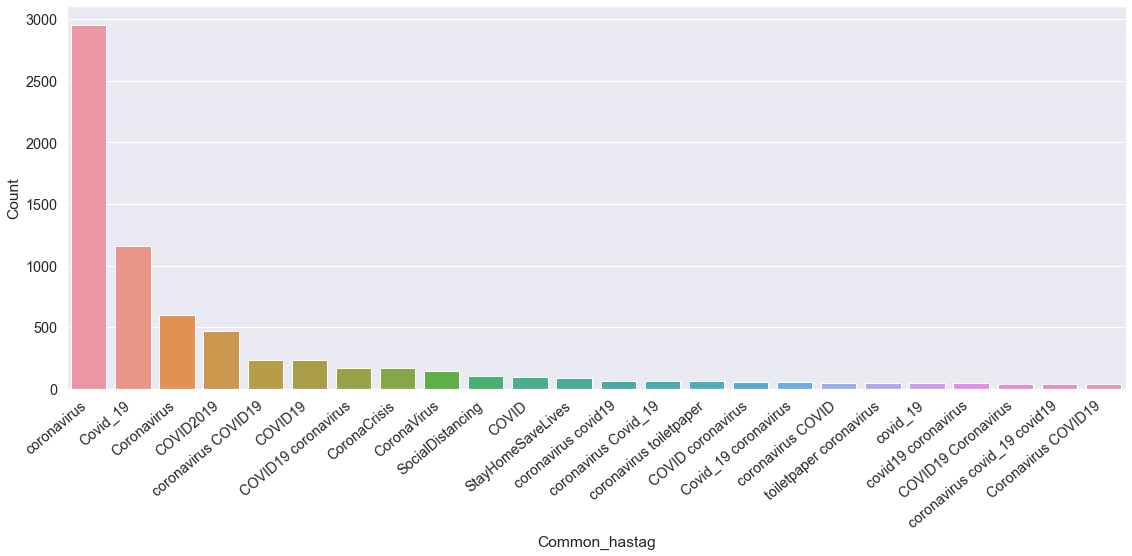

In [11]:
hasht = pd.DataFrame(df['hashtag'].value_counts()[:][1:25].reset_index())
hasht.columns = ['Common_hastag','Count']

plt.figure(figsize=(16,8))
ax=sns.barplot(x="Common_hastag",y="Count", data = hasht)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

## Display Common Mention

In [12]:
def mentions(text):
    line=re.findall(r'(?<=@)\w+',text)
    return " ".join(line)
df['mentions']=df['OriginalTweet'].apply(lambda x:mentions(x))

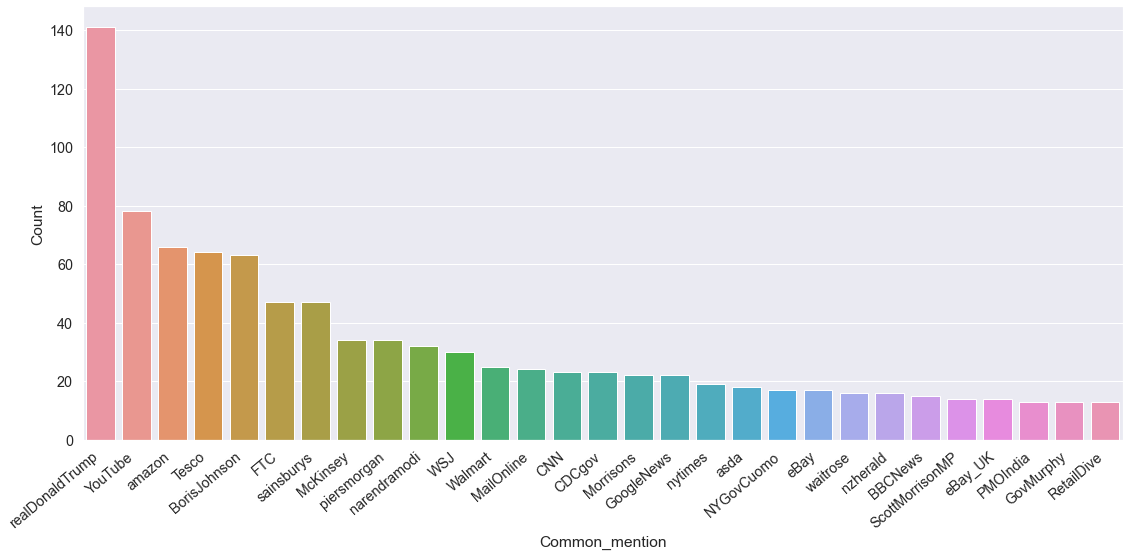

In [13]:
mention = pd.DataFrame(df['mentions'].value_counts()[:][1:30].reset_index())
mention.columns = ['Common_mention','Count']

plt.figure(figsize=(16,8))
ax=sns.barplot(x="Common_mention",y="Count", data = mention)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

# ---------------- Text Processing ----------------

## Lowercase Text

In [14]:
df['lower']=df['OriginalTweet'].str.casefold()

## Remove URLs, Mentions, Special Characters, Hashtags, Punctuations, Numbers

In [15]:
def process(text):
         
        text=BeautifulSoup(text, "html.parser").get_text()
        text=re.sub(r'https?://\S+|www\.\S+','', text)
        text=re.sub(r'@[^\s]+','', text)
        text=text.replace('_','')
        text=re.sub('\[[^]]*\]', '', text)
        text=re.sub(r'[^a-zA-Z0-9\s]','', text)
        text=re.sub('\d+', '', text)
        
        return text
    
df['process']=df['lower'].apply(process)

## Set Stopwords

In [16]:
stop=["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", 
      "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", 
      "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects",
      "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", 
      "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", 
      "always", "am", "amp", "among", "amongst", "amoungst", "amount", "an", "and", "announce", 
      "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", 
      "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", 
      "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", 
      "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", 
      "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", 
      "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", 
      "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", 
      "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond",
      "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", 
      "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", 
      "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain",
      "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", 
      "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", 
      "consider", "considering", "contain", "containing", "contains", "corresponding", 
      "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", 
      "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", 
      "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", 
      "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", 
      "doesn't", "doing", "don", "done", "dont","don't", "down", "downwards", "dp", "dr", "ds", 
      "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", 
      "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", 
      "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", 
      "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", 
      "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere",
      "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", 
      "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", 
      "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", 
      "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", 
      "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", 
      "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", 
      "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", 
      "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", 
      "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", 
      "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", 
      "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", 
      "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", 
      "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", 
      "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", 
      "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", 
      "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", 
      "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir",
      "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "ive", 
      "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", 
      "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", 
      "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", 
      "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", 
      "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", 
      "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe",
      "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", 
      "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", 
      "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn",
      "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", 
      "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", 
      "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", 
      "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", 
      "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o",
      "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", 
      "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", 
      "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", 
      "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", 
      "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount",
      "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", 
      "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", 
      "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", 
      "predominantly", "present", "presumably", "previously", "primarily", "probably", 
      "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", 
      "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily",
      "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", 
      "regards", "related", "relatively", "research", "research-articl", "respectively", 
      "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", 
      "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", 
      "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section",
      "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", 
      "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", 
      "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", 
      "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", 
      "significant", "significantly", "similar", "similarly", "since", "sincere", "six", 
      "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", 
      "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", 
      "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", 
      "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", 
      "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", 
      "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", 
      "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", 
      "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", 
      "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", 
      "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", 
      "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think",
      "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", 
      "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", 
      "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", 
      "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", 
      "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", 
      "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", 
      "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", 
      "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", 
      "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", 
      "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", 
      "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", 
      "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", 
      "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", 
      "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", 
      "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", 
      "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", 
      "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", 
      "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", 
      "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", 
      "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves",
      "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz",]
print(len(stop))

1163


## Remove Stopwords

In [17]:
df['stop']=df['process'].apply(lambda x: ' '.join([word for word in x.split()
                                                             if word not in stop]))

In [18]:
df.rename(columns={'stop': 'Tweet'}, inplace=True)
df=df.drop(['OriginalTweet','lower','process', 'hashtag', 'mentions'], axis=1)

In [19]:
df.head(10)

Sentiment                                              Tweet
0             Neutral                                                   
1            Positive  advice talk neighbours family exchange phone n...
2            Positive  coronavirus australia woolworths elderly disab...
3            Positive  food stock panic food stay calm stay safe covi...
4  Extremely Negative  ready supermarket covid outbreak paranoid food...
5            Positive  news regions confirmed covid case sullivan cou...
6            Positive  cashier grocery store sharing insights covid p...
7             Neutral  supermarket today didnt buy toilet paper rebel...
8            Positive  covid retail store classroom atlanta open walk...
9            Negative  corona preventionwe buy things cash online pay...

# ---------------- Sentiment Analysis -----------------

In [20]:
df['Sentiment'].value_counts()

Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

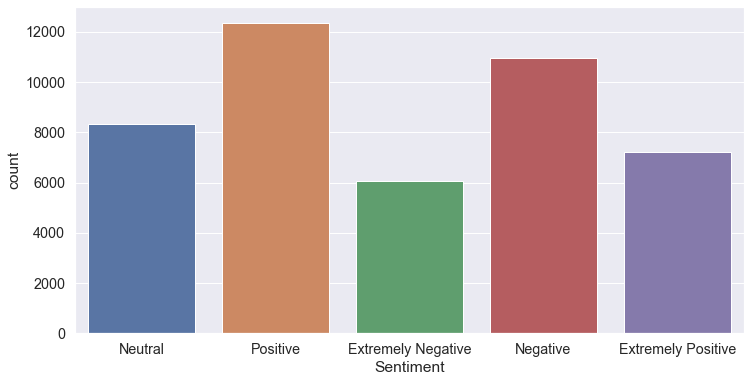

In [21]:
plt.figure(figsize=(12,6))
sns.countplot(x='Sentiment',data=df)

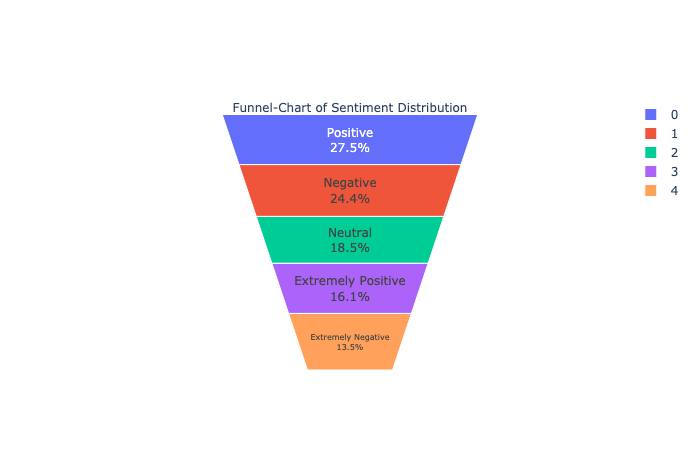

In [22]:
chart = df.groupby('Sentiment').count()['Tweet'].reset_index().sort_values(by='Tweet',ascending=False)
fig = go.Figure(go.Funnelarea(
    text =chart.Sentiment,
    values = chart.Tweet,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show("png")

In [23]:
df['Sentiment'].replace({'Extremely Negative': 'Negative','Extremely Positive': 'Positive'}, inplace=True) 

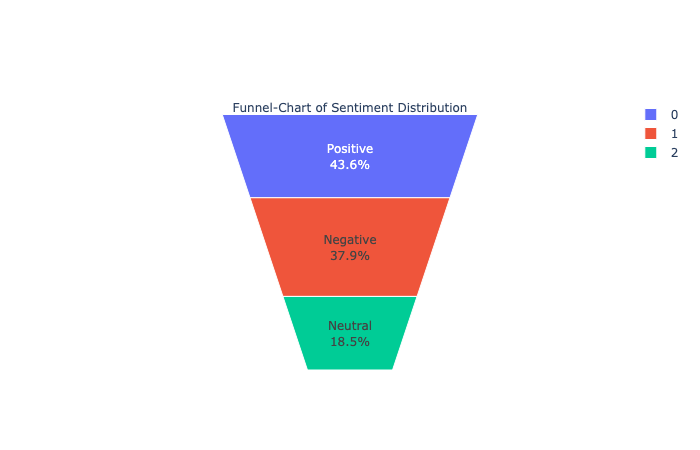

In [24]:
chart1 = df.groupby('Sentiment').count()['Tweet'].reset_index().sort_values(by='Tweet',ascending=False)
fig = go.Figure(go.Funnelarea(
    text =chart1.Sentiment,
    values = chart1.Tweet,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show("png")

## Word Cloud

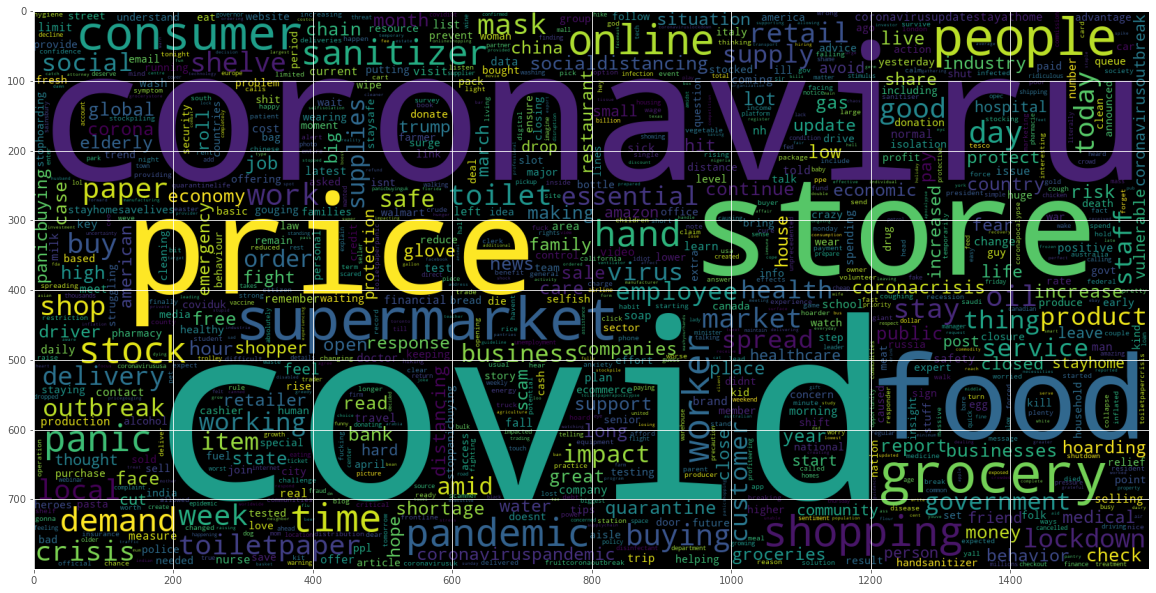

In [31]:
alltweet =df['Tweet']
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(alltweet))
plt.figure(figsize = (20,20))
plt.imshow(wc)

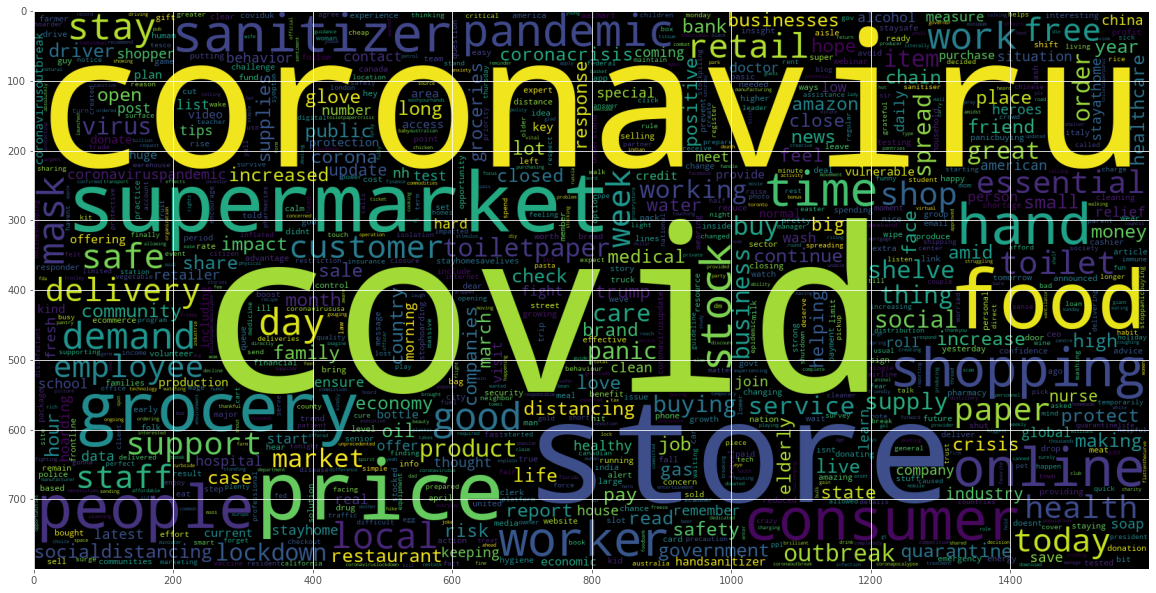

In [32]:
# word cloud for positive tweet 
positive = df.loc[df['Sentiment'] == 'Positive', 'Tweet']
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(positive))
plt.figure(figsize = (20,20))
plt.imshow(wc)

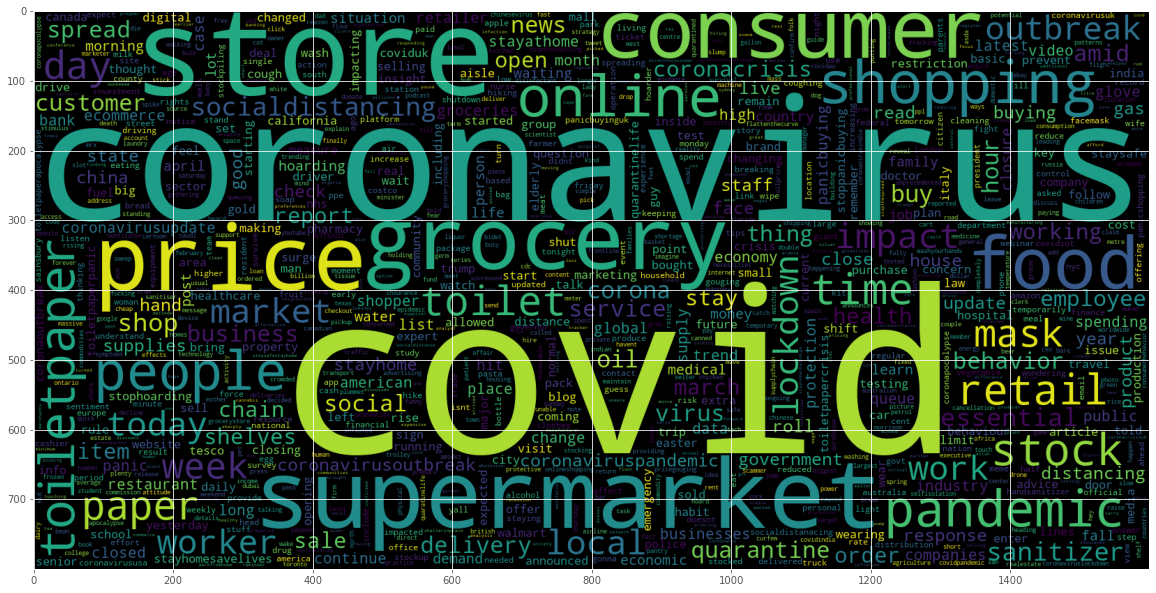

In [34]:
# word cloud for neutral tweet 
neutral = df.loc[df['Sentiment'] == 'Neutral', 'Tweet']
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(neutral))
plt.figure(figsize = (20,20))
plt.imshow(wc)

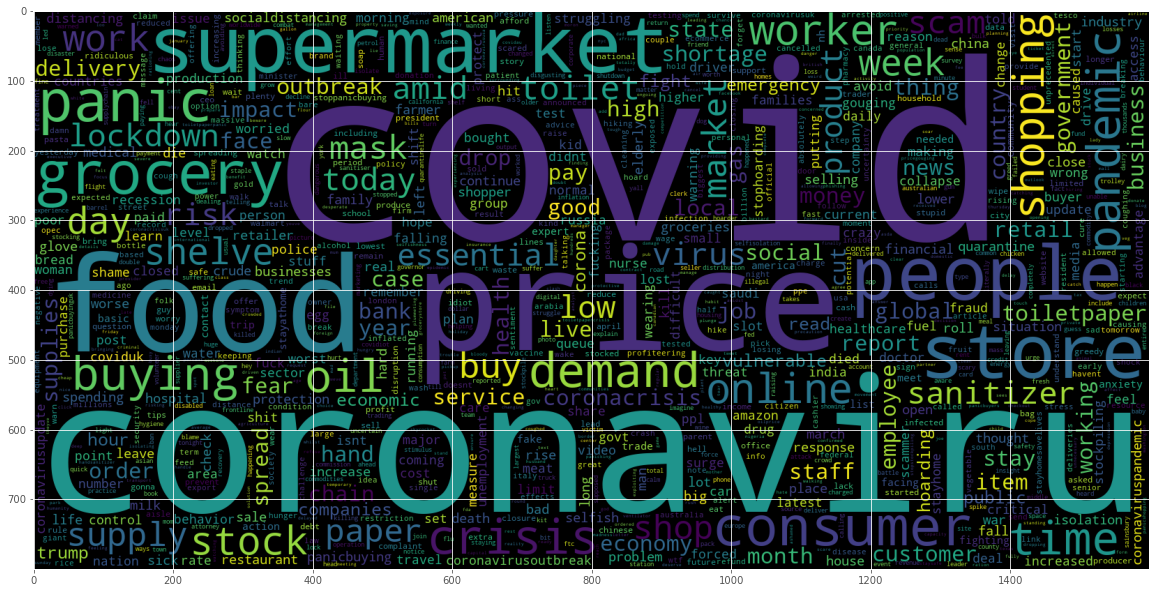

In [36]:
# word cloud for negative tweet 
negative = df.loc[df['Sentiment'] == 'Negative', 'Tweet']
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(negative))
plt.figure(figsize = (20,20))
plt.imshow(wc)

## Wordcloud - Set Stopwords

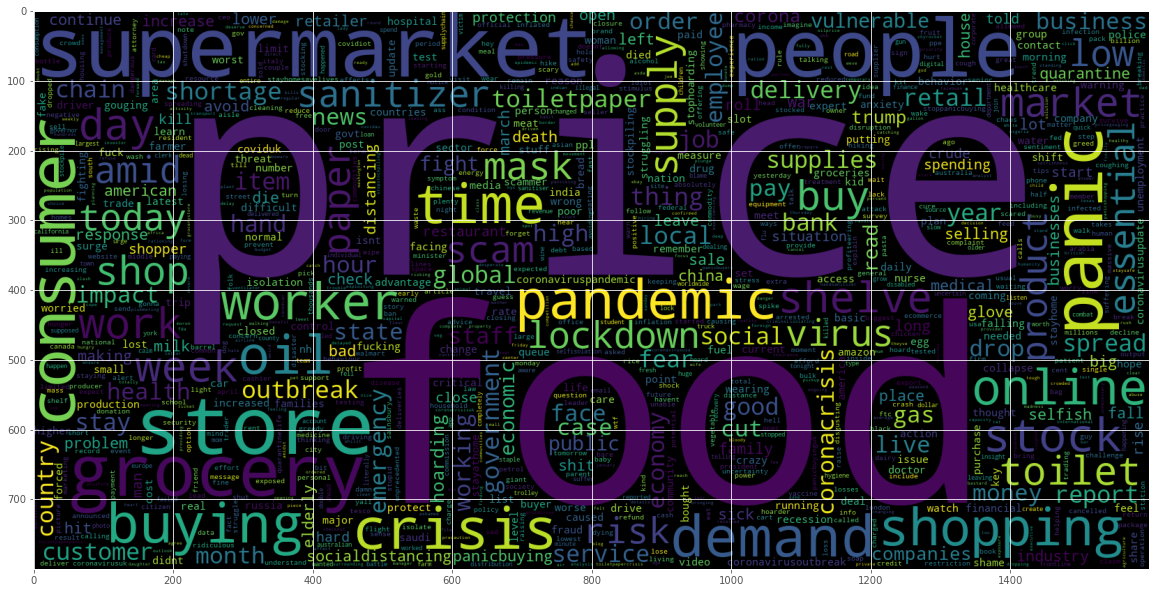

In [37]:
# word cloud for negative tweet 
stopwords = set(STOPWORDS)
stopwords.add("covid")
stopwords.add("coronaviru")
stopwords.add("coronavirus")

negative = df.loc[df['Sentiment'] == 'Negative', 'Tweet']
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, stopwords=stopwords, 
              collocations=False).generate(" ".join(negative))
plt.figure(figsize = (20,20))
plt.imshow(wc)

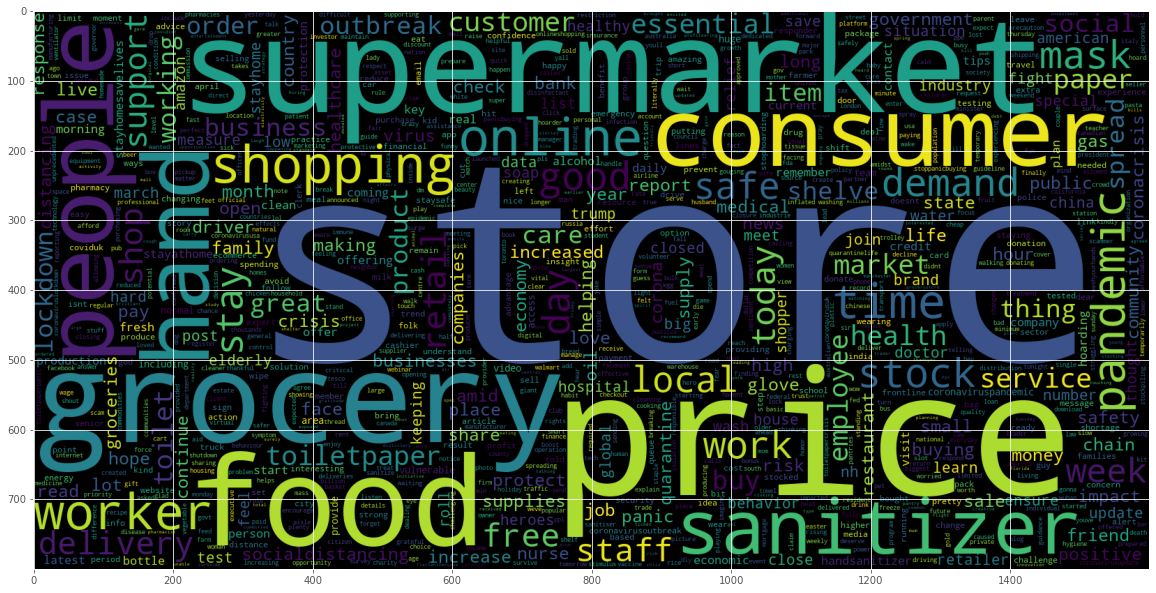

In [38]:
# word cloud for positive tweet 
stopwords = set(STOPWORDS)
stopwords.add("covid")
stopwords.add("coronaviru")
stopwords.add("coronavirus")

positive = df.loc[df['Sentiment'] == 'Positive', 'Tweet']
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, stopwords=stopwords, 
              collocations=False).generate(" ".join(positive))
plt.figure(figsize = (20,20))
plt.imshow(wc)

## Common Words

In [25]:
pos=df.loc[df['Sentiment'] == 'Positive', 'Tweet'].apply(lambda x:str(x).split())
top = Counter([item for sublist in pos for item in sublist])
posi = pd.DataFrame(top.most_common(100))
posi.columns = ['Positive_words','Count']

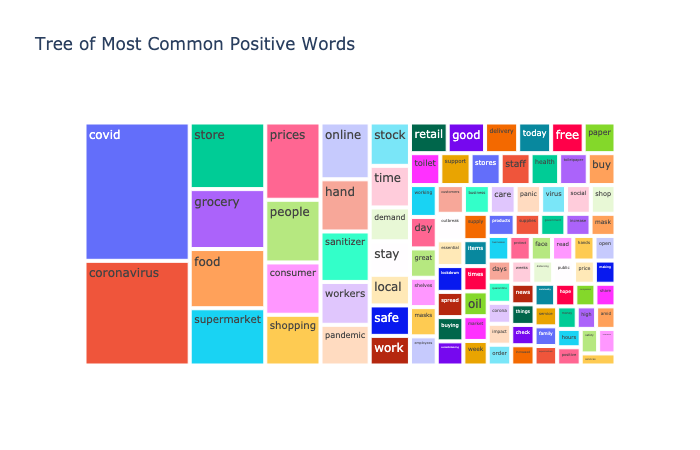

In [26]:
fig = px.treemap(posi, path=['Positive_words'], values='Count',title='Tree of Most Common Positive Words')
fig.show("png")

In [27]:
neg=df.loc[df['Sentiment'] == 'Negative', 'Tweet'].apply(lambda x:str(x).split())
top = Counter([item for sublist in neg for item in sublist])
nega = pd.DataFrame(top.most_common(100))
nega.columns = ['Negative_words','Count']

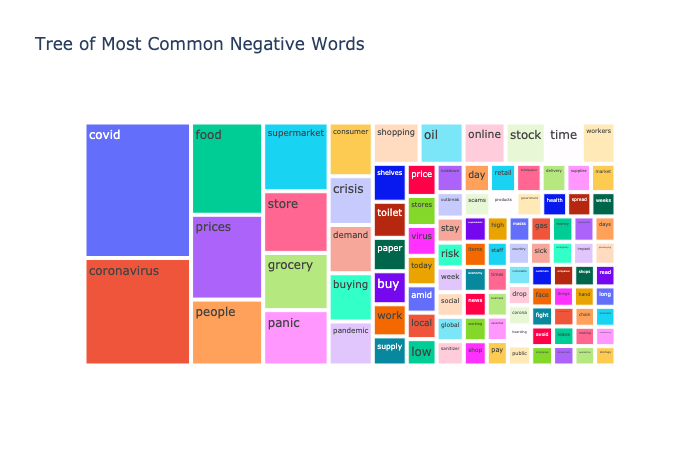

In [28]:
fig = px.treemap(nega, path=['Negative_words'], values='Count',title='Tree of Most Common Negative Words')
fig.show("png")

## Unique Words

In [29]:
posi.rename(columns={'Positive_words': 'Word'}, inplace=True)
nega.rename(columns={'Negative_words': 'Word'}, inplace=True)

In [30]:
common=list(set(nega['Word']).intersection(set(posi['Word'])))
common_wordsn=nega['Word'].value_counts().drop(labels=common).rename_axis('Word')
common_wordsn=pd.DataFrame(common_wordsn).drop(['Word'],axis=1)

In [31]:
mergenega = common_wordsn.merge(nega, on='Word')

In [32]:
common_wordsp=posi['Word'].value_counts().drop(labels=common).rename_axis('Word')
common_wordsp=pd.DataFrame(common_wordsp).drop(['Word'],axis=1)

In [33]:
mergeposi = common_wordsp.merge(posi, on='Word')

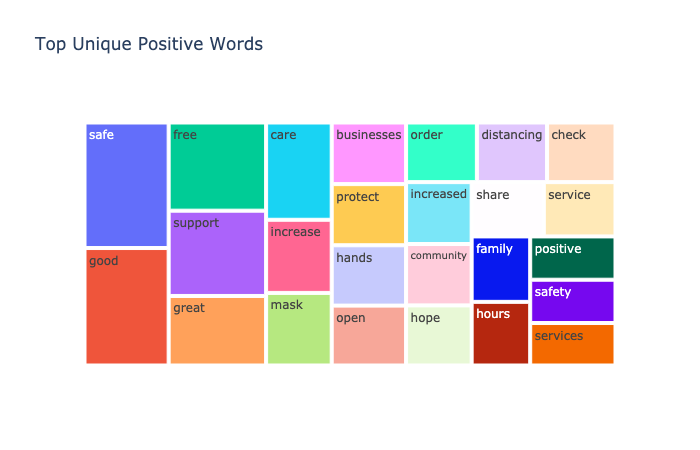

In [34]:
fig = px.treemap(mergeposi, path=['Word'], values='Count',title='Top Unique Positive Words')
fig.show("png")

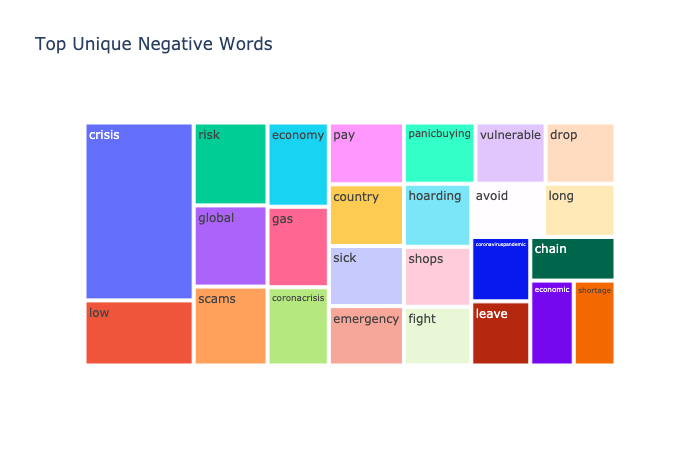

In [35]:
fig = px.treemap(mergenega, path=['Word'], values='Count',title='Top Unique Negative Words')
fig.show("png")

# ---------------- NLP Modeling -----------------

## Tokenize and Lemmatize

In [102]:
df['token'] = df['Tweet'].apply(word_tokenize)

In [103]:
lem = WordNetLemmatizer()
def lemma_wordnet(text):
    return [lem.lemmatize(w) for w in text]
df['lem'] = df['token'].apply(lemma_wordnet)

In [105]:
df=df.drop(['token','Tweet'], axis=1)
df.rename(columns={'lem': 'Tweet'}, inplace=True)

def combine(text):
    combined = ' '.join(text)
    return combined
df['Tweet'] = df['Tweet'].apply(combine)

## Sentiment Encoding 

In [114]:
encoding = {'Negative': 0,
            'Neutral': 1,
            'Positive':2,
           }

labels = ['Negative', 'Neutral', 'Positive']
           
df['Sentiment'].replace(encoding, inplace=True) #less label

## TF-IDF

In [332]:
X = df["Tweet"].tolist()
y = df["Sentiment"].tolist()

In [298]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=37)

In [260]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [261]:
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
dic_vocabulary = vectorizer.vocabulary_

## MultinomialNB 

In [266]:
classifier = MultinomialNB()

In [268]:
# pipeline
model = Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
# train classifier
model["classifier"].fit(X_train, y_train)
# test
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.63
Auc: 0.83
Detail:
              precision    recall  f1-score   support

           0       0.72      0.68      0.70      1690
           1       0.85      0.01      0.02       871
           2       0.59      0.87      0.70      1935

    accuracy                           0.63      4496
   macro avg       0.72      0.52      0.48      4496
weighted avg       0.69      0.63      0.57      4496



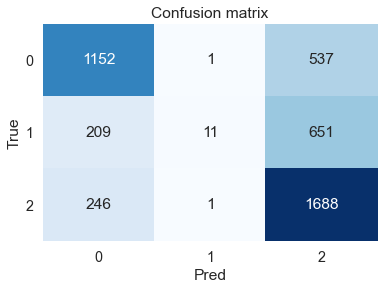

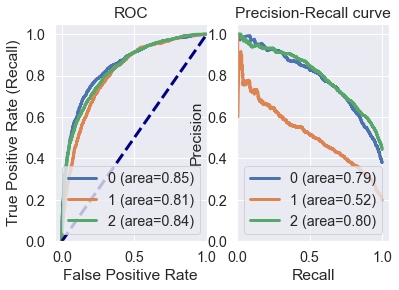

<Figure size 2880x1440 with 0 Axes>

In [480]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
accuracy = accuracy_score(y_test, predicted)
auc = roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print( classification_report(y_test, predicted))
    
cm = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
fig = plt.figure(figsize=(40,20))

for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="ROC")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

## SGDClassifier 

In [317]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (20,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__max_iter': (10, 50, 80),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
print("\n")
print("Classification Report Test Data")
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__max_iter': (10, 50, 80),
 'clf__penalty': ('l2', 'elasticnet'),
 'tfidf__norm': ('l1', 'l2'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__max_features': (None, 5000, 10000, 50000),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
done in 28862.189s

Best score: 0.759
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 80
	clf__penalty: 'elasticnet'
	tfidf__norm: 'l2'
	tfidf__use_idf: False
	vect__max_df: 0.5
	vect__max_features: 10000
	vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.768


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1690
           1       0.63      0.67      0.65       871
           2       0.80      0.80      0.80      1935

    accuracy                           

## LSTM

In [402]:
X = df["Tweet"]
y = df["Sentiment"]

In [403]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
vocab_size = len(tokenizer.word_index)+1
print("Vocabulary size: {}".format(vocab_size))
print("\nAfter tokenizing :\n{}".format(X[6]))
X = pad_sequences(X, padding='post')
print("\nAfter padding :\n{}".format(X[6]))

Vocabulary size: 45686

After tokenizing :
[382, 7, 4, 1016, 384, 1, 2368, 9210, 9211, 18772, 760, 656]

After padding :
[  382     7     4  1016   384     1  2368  9210  9211 18772   760   656
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0]


In [404]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=37)

In [465]:
tensorflow.keras.backend.clear_session()

EPOCHS = 2
BATCH_SIZE = 32
embedding_dim = 16
units = 256

model = Sequential()
model.add(keras.layers.Embedding(vocab_size, embedding_dim, input_length=X_train.shape[1]))
model.add(keras.layers.Bidirectional(L.LSTM(units,return_sequences=True)))
model.add(keras.layers.GlobalMaxPool1D())
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation="relu"))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(3))

model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 34, 16)            730976    
_________________________________________________________________
bidirectional (Bidirectional (None, 34, 512)           559104    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                8208      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 5

In [449]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.12, batch_size=BATCH_SIZE, shuffle=True, callbacks=[es_callback])
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/2
1113/1113 [==============================] - 185s 163ms/step - loss: 0.9785 - accuracy: 0.4963 - val_loss: 0.6677 - val_accuracy: 0.7477
Epoch 2/2
1113/1113 [==============================] - 177s 159ms/step - loss: 0.6128 - accuracy: 0.7825 - val_loss: 0.6073 - val_accuracy: 0.7727
Test loss: 0.618502140045166
Test accuracy: 0.7675711512565613


In [450]:
fig = px.line(
    history.history, y=['accuracy', 'val_accuracy'],
    labels={'index': 'epoch', 'value': 'accuracy'}
)
fig.show()

In [451]:
fig = px.line(
    history.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}
)

fig.show()

In [483]:
pred = model.predict_classes(X_test)

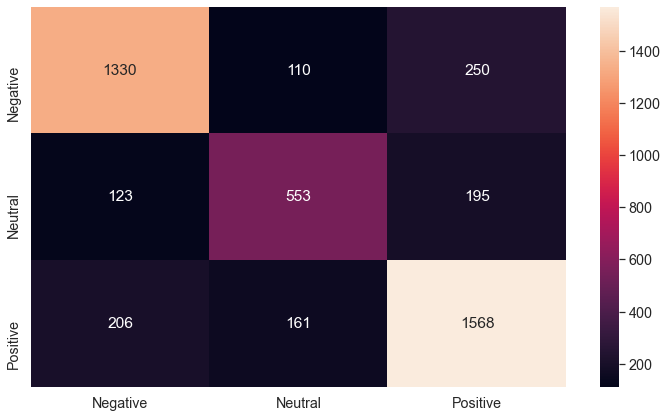

In [462]:
conf = confusion_matrix(y_test, pred)

cm = pd.DataFrame(
    conf, index = [i for i in labels],
    columns = [i for i in labels]
)

plt.figure(figsize = (12,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [463]:
print(classification_report(y_test, pred, target_names=labels))

              precision    recall  f1-score   support

    Negative       0.80      0.79      0.79      1690
     Neutral       0.67      0.63      0.65       871
    Positive       0.78      0.81      0.79      1935

    accuracy                           0.77      4496
   macro avg       0.75      0.74      0.75      4496
weighted avg       0.77      0.77      0.77      4496



# --------------- Future Improvement ---------------

## Detailed Text Processing - Abbreviation

In [ ]:
# def special(text):
    
    text=re.sub(r'afaik','as far as i know', text)
    text=re.sub(r'afk','away from keyboard', text)
    text=re.sub(r'asap','as soon as possible', text)
    text=re.sub(r'atk','at the keyboard', text)
    text=re.sub(r'atm','at the moment', text)
    text=re.sub(r'a3','anytime', text)
    text=re.sub(r'bak','back at keyboard', text)
    text=re.sub(r'bbl','be back later', text)
    text=re.sub(r'bbs','be back soon', text)
    text=re.sub(r'bfn','bye for now', text)
    text=re.sub(r'b4n','bye for now', text)
    text=re.sub(r'brb','be right back', text)
    text=re.sub(r'brt','be right there', text)
    text=re.sub(r'btw','by the way', text)
    text=re.sub(r'b4','before', text)
    text=re.sub(r'b4n','bye for now', text)
    text=re.sub(r'cu','see you', text)
    text=re.sub(r'cul8r','see you later', text)
    text=re.sub(r'cya','see you', text)
    text=re.sub(r'faq','frequently asked questions', text)
    text=re.sub(r'fc','fingers crossed', text)
    text=re.sub(r'fwiw','for what it is worth', text)
    text=re.sub(r'fyi','for your information', text)
    text=re.sub(r'gal','get a life', text)
    text=re.sub(r'gg','good game', text)
    text=re.sub(r'gn','good night', text)
    text=re.sub(r'gmta','great minds think alike', text)
    text=re.sub(r'gr8','great', text)
    text=re.sub(r'g9','genius', text)
    text=re.sub(r'ic','i see', text)
    text=re.sub(r'icq','i seek you', text)
    text=re.sub(r'ilu','i love you', text)
    text=re.sub(r'imho','in my honest opinion', text)
    text=re.sub(r'imo','in my opinion', text)
    text=re.sub(r'iow','in other words', text)
    text=re.sub(r'irl','in real life', text)
    text=re.sub(r'kiss','keep it simple stupid', text)
    text=re.sub(r'ldr','long distance relationship', text)
    text=re.sub(r'lmao','laugh my a off', text)
    text=re.sub(r'lol','laughing out loud', text)
    text=re.sub(r'ltns','long time no see', text)
    text=re.sub(r'l8r','later', text)
    text=re.sub(r'mte','my thoughts exactly', text)
    text=re.sub(r'm8','mate', text)
    text=re.sub(r'nrn','no reply necessary', text)
    text=re.sub(r'oic','oh i see', text)
    text=re.sub(r'prt','party', text)
    text=re.sub(r'prw','parents are watching', text)
    text=re.sub(r'rn','right now', text)
    text=re.sub(r'rofl','rolling on the floor laughing', text)
    text=re.sub(r'roflol','rolling on the floor laughing out loud', text)
    text=re.sub(r'rotflmao','rolling on the floor laughing my a off', text)
    text=re.sub(r'sk8','skate', text)
    text=re.sub(r'stats','your sex and age', text)
    text=re.sub(r'asl','age sex location', text)
    text=re.sub(r'thx','thank you', text)
    text=re.sub(r'ttfn','ta ta for now', text)
    text=re.sub(r'ttyl','talk to you later', text)
    text=re.sub(r'tho','though', text)
    text=re.sub(r'u','you', text)
    text=re.sub(r'u2','you too', text)
    text=re.sub(r'u4e','yours for ever', text)
    text=re.sub(r'wb','welcome back', text)
    text=re.sub(r'wtf','what the fxxx', text)
    text=re.sub(r'wtg','way to go', text)
    text=re.sub(r'wuf','where are you from', text)
    text=re.sub(r'w8','wait', text)
    text=re.sub(r'7k','sick', text)
    
    return str(text)
    
train['special']=train['text'].apply(special)

## Spell Check

In [ ]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        elif word not in misspelled_words:
            corrected_text.append(word)
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
train['spell']=train['text'].apply(correct_spellings)